## PERFORMANCE EVALUATION OF CLUSTERING TECHNIQUES FOR IMAGE SEGMENTATION

Image segmentation is a highly useful technique for digital picture processing and image analysis, and clustering is an approach that has been severally applied to this task in the literature. This notebook focuses on the implementation of these clustering algorithms with respect to image segmentation, and the performance evaluation on each algorithm.
First of all, clustering is an unsupervised technique in which the model groups data point using similar characteristics of those point using statistical features. It doesnt involve using labels when training like the supervised techniques therefore evaluation of clustering techniques is often overlooked as there are no labels and targets for the evaluation. 
In respect to this, the approach we would take is the "ground truth" method, where a ground truth is given as the measure of performance accoriding to the dataset in question.

#### Methdology for finding the predicted and the ground truth binary mask

When performing clustering on image segmentation, we would use only the image itself without applying the depth and masks so therefore the technique of clustering would be used to partition data points into cluster based on feature vectors. Depth would have been used here if we were not applying clustering. For performance evaluation, the predicted binary mask and the ground truth binary mask would be compared; the predicted mask is gotten after the clustering algorithm has been performed, cluster labels obtained and converted to binary mask while the ground truth binary mask can be gotten by manual dataset annotation or from an already existing labelled datasets.

## Dataset

We would be using the widely used carvana dataset for computer vision which comprises of different images of car images and masks in form of images . This dataset contain the images and masks contents. For detailed information and guidelines on the dataset, the official website is as follows:
https://www.kaggle.com/c/carvana-image-masking-challenge

### Implementation

This notebook will be implemented using python mainly as the programming language and the pytorch framework for deep learning and sklearn library for classical machine learning algorithms.

### Importing relevant libraries to prepare dataset

In [1]:
import skimage

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
import os
import numpy as np
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
root_dir =  "C:/Users/Hp/Documents/ML/SEGMENTATION"
image_file = "C:/Users/Hp/Documents/ML/SEGMENTATION/train"
mask_file = "C:/Users/Hp/Documents/ML/SEGMENTATION/train_masks"

### Creating a custom dataclass for the Carvana dataset

In [4]:
class CustomCarvanaDataset(Dataset):
    def __init__(self, root_dir, image_file, mask_file, transform = None):
        self.root_dir = root_dir
        self.image_file = image_file
        self.mask_file = mask_file
        self.image_file_paths = [os.path.join(image_file, img) for img in (os.listdir(image_file))]
        self.mask_file_paths = [os.path.join(mask_file, mask) for mask in (os.listdir(mask_file))]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_file_paths)
    
    def ground_truth_bin_mask(self):
        for root, _, files in os.walk(mask_file):
            for file_name in files:
                gif_path = os.path.join(root, file_name)
                image_m = io.imread(gif_path)
                image_m = np.array(image_m)
                image_m[image_m > 0] = 1
            return image_m        
        
    def __getitem__(self, idx):
        image_path = self.image_file_paths[idx]
        mask = self.mask_file_paths[idx]
        image = Image.open(image_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
        return image, mask

Now we apply data augmentation using transforms. This augmentation helps to increase the dataset size and model performance.Some augmentations such as rotations and flips can help the model learn to be invariant to the transforms. We will implement the resize, rotation, horizontal and vertical flip transforms.

In [5]:
## defining transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

In [6]:
dataset = CustomCarvanaDataset(root_dir = root_dir, image_file = image_file, mask_file = mask_file, transform=transform)

In [7]:
#dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
# checking the shape
first_batch = next(iter(dataloader))

In [9]:
ground_bin_mask = dataset.ground_truth_bin_mask()

In [10]:
ground_bin_mask.shape

(1280, 1918)

In [11]:
inputs = first_batch

In [12]:
inputs[0].shape

torch.Size([32, 1, 100, 100])

## APPLYING THE CLUSTERING ALGORITHMS

Mertics for evaluation:
- Jaccard index
- Rand index
- Fowlkes-Mallows index
- Precision, Recall, F1-score.

## Importing the libraries for the metrics for evaluation

In [13]:
from sklearn.metrics import jaccard_score, adjusted_rand_score, fowlkes_mallows_score, precision_score, recall_score, f1_score

## K-means clustering

In [14]:
from sklearn.cluster import KMeans

In [15]:
# getting data from the dataloader
kmeans_data = []
for batch in dataloader:
    kmeans_data.append(batch[0])
kmeans_data_1 = torch.cat(kmeans_data, dim=0).numpy()

In [16]:
kmeans_data[0].shape

torch.Size([32, 1, 100, 100])

#### elblow method to determine k

In [17]:
# checking the shape of the data and found out to be 5D
kmeans_data_1.shape

(5088, 1, 100, 100)

In [18]:
# converting the 4D array to a 2D array to fit the kmeans model
kmeans_flat = kmeans_data_1.reshape((5088 * 1 * 100, 100))

In [19]:
def determine_best_k(data, max_k):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters = k, random_state = 0)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    # plot elbow
    plt.plot(range(1, max_k + 1), distortions, marker = "o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Distortion")
    plt.title("elbow")
    plt.show()
    
    #determine best k based on elbow
    deltas = np.diff(distortions)
    acceleration = np.diff(deltas)
    best_k = acceleration.argmax() + 2
    
    return best_k

In [20]:
max_k = 5

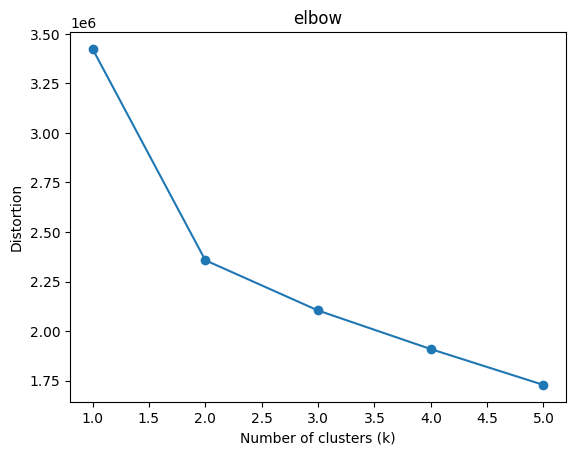

In [21]:
best_k = determine_best_k(kmeans_flat, max_k)

In [22]:
# create and fit the kmeans model using the best k from the elbow method
kmeans = KMeans(n_clusters=2)

In [23]:
kmeans.fit(kmeans_flat)

KMeans(n_clusters=2)

In [24]:
cluster_labels = kmeans.labels_

In [25]:
cluster_labels

array([0, 0, 1, ..., 1, 1, 0])

#### converting cluster labels to binary mask

In [26]:
image_shape = (508800, 100)

In [27]:
pred_binary_mask = np.zeros(image_shape, dtype = np.uint8)
for label, pixel_value in enumerate(np.unique(cluster_labels)):
    pred_binary_mask[np.where(np.array(cluster_labels) == pixel_value)] = label

In [28]:
pred_binary_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [29]:
ground_bin_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [53]:
pred_binary_mask.shape

(1280, 100)

In [55]:
ground_bin_mask.shape

(1280, 1918)

#### resizing the predicted binary mask to the ground binary mask

In [32]:
from skimage.transform import resize

In [56]:
target_size = ground_bin_mask.shape

In [57]:
resized_pred_bin_mask = resize(pred_binary_mask, target_size, order=0, mode="constant", anti_aliasing=False)

In [58]:
resized_pred_bin_mask.shape

In [64]:
# flattening the arrays to 1D
ground_bin_mask_flat = ground_bin_mask.ravel()
pred_bin_mask_flat = pred_binary_mask.ravel()

#### jaccard index evaluation

In [41]:
jaccard_index = jaccard_score(ground_bin_mask_flat, resized_pred_bin_mask_flat)

In [42]:
jaccard_index

0.19668701299573196

#### rand index

In [43]:
rand_index = adjusted_rand_score(ground_bin_mask_flat, resized_pred_bin_mask_flat)

In [44]:
rand_index

-0.00014352482469845803

#### fowlkes mallow score

In [45]:
fowlkes_score = fowlkes_mallows_score(ground_bin_mask_flat, resized_pred_bin_mask_flat)

In [46]:
fowlkes_score

0.573078931376261

#### precision score

In [47]:
precision = precision_score(ground_bin_mask_flat, resized_pred_bin_mask_flat)

In [48]:
precision

0.2311153439578424

#### recall score

In [49]:
recall = recall_score(ground_bin_mask_flat, resized_pred_bin_mask_flat)

In [50]:
recall

0.5690302098213261

#### f1 score

In [51]:
f1_score = f1_score(ground_bin_mask_flat, resized_pred_bin_mask_flat)

In [52]:
f1_score

0.32871922375651863